In [24]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#### Part 1: Data Loading and Preparation

In [25]:
# Load all sheets from the Excel file
file_path = 'HrData.xlsx'
employee_df = pd.read_excel(file_path, sheet_name='Employee')
performance_df = pd.read_excel(file_path, sheet_name='PerformanceRating')
education_level_df = pd.read_excel(file_path, sheet_name='EducationLevel')
rating_level_df = pd.read_excel(file_path, sheet_name='RatingLevel')
satisfied_level_df = pd.read_excel(file_path, sheet_name='SatisfiedLevel')

# Convert date columns to datetime
employee_df['HireDate'] = pd.to_datetime(employee_df['HireDate'])
performance_df['ReviewDate'] = pd.to_datetime(performance_df['ReviewDate'])

# Verify data loading
print("Employee Data Sample:")
print(employee_df.head())
print("\nPerformance Rating Data Sample:")
print(performance_df.head())

Employee Data Sample:
  EmployeeID   FirstName LastName      Gender  Age BusinessTravel  \
0  3012-1A41    Leonelle    Simco      Female   30    Some Travel   
1  CBCB-9C9D     Leonerd    Aland        Male   38    Some Travel   
2  95D7-1CE9       Ahmed    Sykes        Male   43    Some Travel   
3  47A0-559B  Ermentrude   Berrie  Non-Binary   39    Some Travel   
4  42CC-040A       Stace   Savege      Female   29    Some Travel   

        Department  DistanceFromHome State                Ethnicity  ...  \
0            Sales                27    IL                    White  ...   
1            Sales                23    CA                    White  ...   
2  Human Resources                29    CA  Asian or Asian American  ...   
3       Technology                12    IL                    White  ...   
4  Human Resources                29    CA                    White  ...   

   MaritalStatus  Salary StockOptionLevel OverTime   HireDate  Attrition  \
0       Divorced  102059      

#### Step 2: GAP Analysis

> Objective: Identify the gap between each employee's current performance (ManagerRating) and the desired performance (average ManagerRating for their JobRole). Visualize the distribution of gaps and assess the impact of training (TrainingOpportunitiesTaken) on performance gaps.

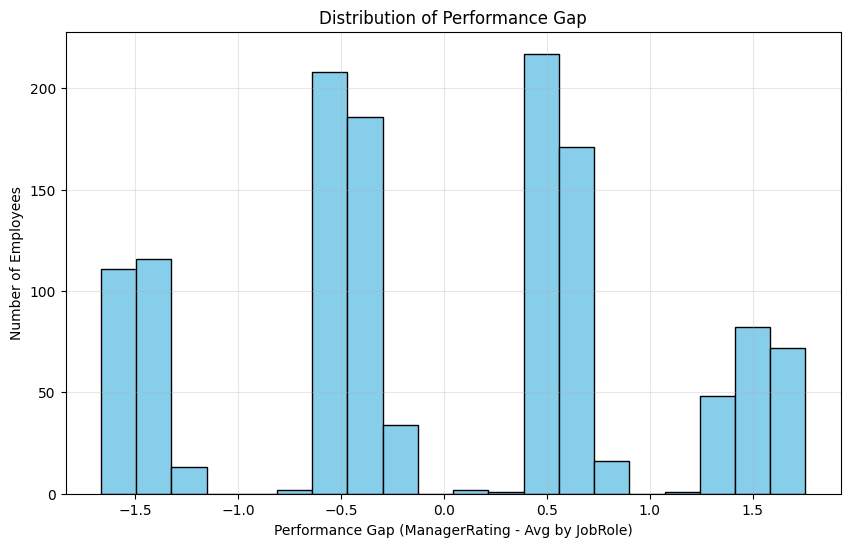

Percentage of employees performing below their job role average: 45.58%
Correlation between Performance Gap and TrainingOpportunitiesTaken: 0.01


In [26]:
# Get the most recent performance review per employee
latest_performance = performance_df.loc[performance_df.groupby('EmployeeID')['ReviewDate'].idxmax()]

# Merge with employee data
merged_df = pd.merge(employee_df, latest_performance, on='EmployeeID', how='left')

# Calculate average ManagerRating per JobRole
avg_rating_by_role = merged_df.groupby('JobRole')['ManagerRating'].mean()

# Compute the performance gap
merged_df['Gap'] = merged_df['ManagerRating'] - merged_df['JobRole'].map(avg_rating_by_role)

# Visualize the distribution of gaps
plt.figure(figsize=(10, 6))
plt.hist(merged_df['Gap'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Performance Gap')
plt.xlabel('Performance Gap (ManagerRating - Avg by JobRole)')
plt.ylabel('Number of Employees')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate percentage of employees with a negative gap
negative_gap_pct = (merged_df['Gap'] < 0).mean() * 100
print(f"Percentage of employees performing below their job role average: {negative_gap_pct:.2f}%")

# Explore correlation with training opportunities taken
correlation = merged_df['Gap'].corr(merged_df['TrainingOpportunitiesTaken'])
print(f"Correlation between Performance Gap and TrainingOpportunitiesTaken: {correlation:.2f}")

#### Step 3: 9-Box Grid Analysis

> Objective: Classify employees into a 3x3 grid based on current performance (ManagerRating) and future potential (trend of ManagerRating over time, calculated as a slope). This aids in identifying high-potential employees and those needing development or redeployment.

In [28]:
# Function to calculate the slope of ManagerRating over time
def calculate_slope(group):
    if len(group) < 2:  # Need at least 2 points for a trend
        return np.nan
    X = (group['ReviewDate'] - group['ReviewDate'].min()).dt.days.values.reshape(-1, 1)
    y = group['ManagerRating'].values
    model = LinearRegression().fit(X, y)
    return model.coef_[0]

# Calculate slopes for each employee
slopes = performance_df.groupby('EmployeeID').apply(calculate_slope)
merged_df['Slope'] = merged_df['EmployeeID'].map(slopes)

# Categorize ManagerRating into performance levels
def categorize_performance(rating):
    if pd.isna(rating):
        return np.nan
    elif rating <= 2:
        return 'Low'
    elif rating == 3:
        return 'Average'
    else:  # 4 or 5
        return 'High'

merged_df['PerformanceCategory'] = merged_df['ManagerRating'].apply(categorize_performance)

# Filter employees with valid slopes and categorize potential
valid_df = merged_df.dropna(subset=['Slope'])
valid_df['PotentialCategory'] = pd.qcut(valid_df['Slope'], 3, labels=['Low', 'Average', 'High'])

# Create the 9-box grid
grid = pd.crosstab(valid_df['PerformanceCategory'], valid_df['PotentialCategory'])
print("9-Box Grid Distribution:")
print(grid)

# Visualize with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(grid, annot=True, fmt='d', cmap='Blues')
plt.title('9-Box Grid: Performance vs. Potential')
plt.xlabel('Future Potential')
plt.ylabel('Current Performance')
plt.show()

NameError: name 'LinearRegression' is not defined

#### Step 4: Balanced Scorecard Analysis
> Objective: 

> Evaluate HR performance across four perspectives:
- Financial: Attrition rate as a cost indicator.
- Employee Satisfaction: Average satisfaction across multiple dimensions.
- Internal Processes: Efficiency of training utilization and promotion frequency.
- Learning and Growth: Engagement in training and recent promotion rates. Visualize key metrics for a comprehensive overview.

Attrition Rate: 16.12%
Overall Average Satisfaction (1-5 scale): 3.46
Average Training Utilization: 0.46
Average Years Since Last Promotion: 3.44
Average Training Opportunities Taken: 0.83
Percentage of Employees with Promotion in Last Year: 34.83%


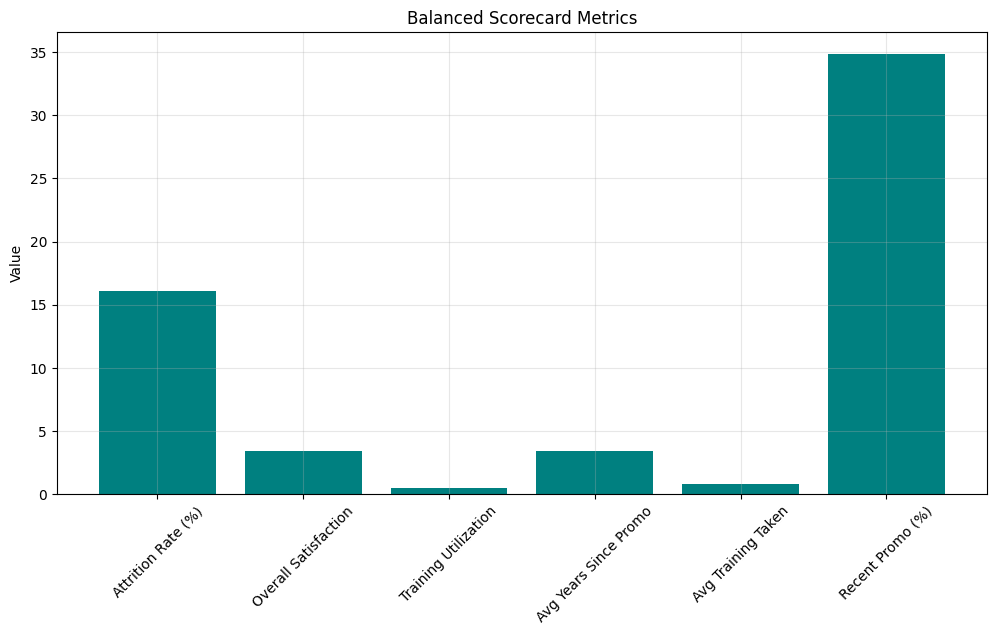

In [29]:
# Financial Perspective: Attrition Rate
attrition_rate = (employee_df['Attrition'] == 'Yes').mean() * 100
print(f"Attrition Rate: {attrition_rate:.2f}%")

# Employee Satisfaction: Average satisfaction scores from latest review
satisfaction_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 
                     'RelationshipSatisfaction', 'WorkLifeBalance']
latest_performance['OverallSatisfaction'] = latest_performance[satisfaction_cols].mean(axis=1)
overall_satisfaction = latest_performance['OverallSatisfaction'].mean()
print(f"Overall Average Satisfaction (1-5 scale): {overall_satisfaction:.2f}")

# Internal Processes: Training Utilization and Years Since Last Promotion
latest_performance['TrainingUtilization'] = (latest_performance['TrainingOpportunitiesTaken'] / 
                                             latest_performance['TrainingOpportunitiesWithinYear'].replace(0, np.nan))
avg_training_utilization = latest_performance['TrainingUtilization'].mean()
print(f"Average Training Utilization: {avg_training_utilization:.2f}")

avg_years_since_promo = employee_df['YearsSinceLastPromotion'].mean()
print(f"Average Years Since Last Promotion: {avg_years_since_promo:.2f}")

# Learning and Growth: Training Opportunities Taken and Recent Promotions
avg_training_taken = latest_performance['TrainingOpportunitiesTaken'].mean()
print(f"Average Training Opportunities Taken: {avg_training_taken:.2f}")

recent_promo_pct = (employee_df['YearsSinceLastPromotion'] <= 1).mean() * 100
print(f"Percentage of Employees with Promotion in Last Year: {recent_promo_pct:.2f}%")

# Visualize key metrics
metrics = {
    'Attrition Rate (%)': attrition_rate,
    'Overall Satisfaction': overall_satisfaction,
    'Training Utilization': avg_training_utilization,
    'Avg Years Since Promo': avg_years_since_promo,
    'Avg Training Taken': avg_training_taken,
    'Recent Promo (%)': recent_promo_pct
}

plt.figure(figsize=(12, 6))
plt.bar(metrics.keys(), metrics.values(), color='teal')
plt.title('Balanced Scorecard Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

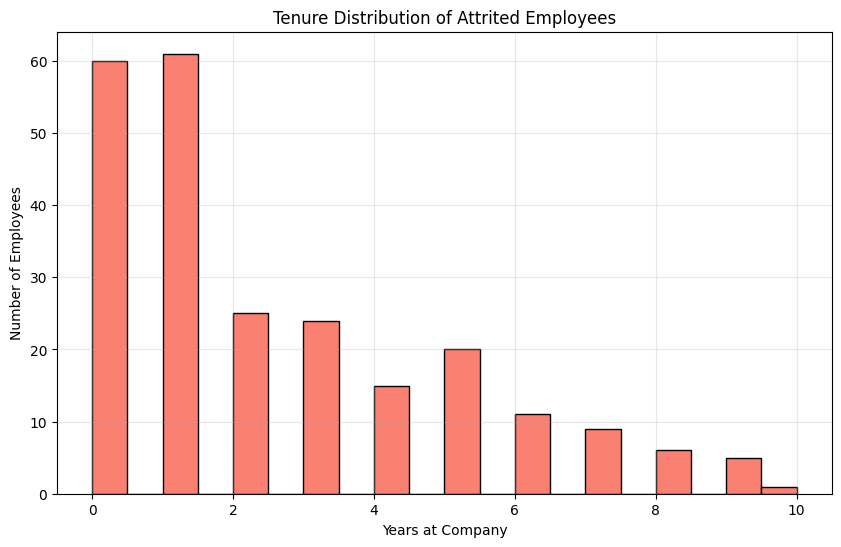

In [13]:
# Histogram of tenure for attrited employees
plt.figure(figsize=(10, 6))
plt.hist(df_turnover['Tenure'], bins=20, color='salmon', edgecolor='black')
plt.title('Tenure Distribution of Attrited Employees')
plt.xlabel('Years at Company')
plt.ylabel('Number of Employees')
plt.grid(True, alpha=0.3)
plt.show()